# COMP41680 - Text Scraping Assignment
## Name - JEET BANERJEE
## Student Number - 17200844

## Part 1. Data Collection

### Import libraries and packages

In [1]:
import os
import urllib.request
from urllib.parse import urljoin
import csv
import pandas as pd 
import json
import numpy as np
import requests
from bs4 import BeautifulSoup

Data Collection for all news articles as present in http://mlg.ucd.ie/modules/COMP41680/archive/index.html

In [2]:
base_url = "http://mlg.ucd.ie/modules/COMP41680/archive/"
index_url ="index.html"
url = urljoin(base_url, index_url)

Send Request to the URL and use BeautifulSoup package to extract the information using an HTML parser

In [3]:
response = urllib.request.urlopen(url).read()
soup = BeautifulSoup(response, "html.parser")

Method to initialise the Category CSV file and store the categories in the file

In [4]:
def create_new_category_file():
    #initialise an empty file and truncate it
    with open('category.csv', 'w') as file:
        file.truncate()
    file.close()
    
def create_category_labels(categories):
    # store the category of each news article (in append mode of the file)
    with open('category.csv', 'a') as file:
        for c in categories:
            category = c.get_text().strip()
            # Get the category and store it only if it is not 'N/A'
            if category != "N/A":
                file.write(category)
                file.write('\n')
    file.close()

Method to create a text file for body of each news article.

In [5]:
# Store the body of each news article
def create_body_text_file(content, counter):
    # Open the appropriate file using the counter value to get the file number
    filename = "file" + str(counter) + ".txt"
    with open(filename, 'w') as file:
        file.write(content)
    file.close()

Method to get contents of the body of each news article using the BeatifulSoup object

In [6]:
# get contents of the body of each news article from the soup object
def get_body_contents_of_page(soup):
    soup.find('p', class_='notice').decompose() # remove <p class="notice"> content from each article
    all_para = soup.find_all(["p","b"]) # Find all <p> and <b> tags in the soup
    body_of_page = ""
    for para in all_para:
        body_of_page+=(para.get_text()+" ") # Append the text of all the title <b> and body <p> tags to a string
    return body_of_page

### Begin Web Scraping
Find all links present in the Home page 

In [7]:
home_page_links = soup.find_all("a", href=True)
# If a link contains an href, store it in an array called home_page_links
home_page_links = [link for link in home_page_links if link['href']]

Initialise the new file, loop for all home page links, and send request to each link in the home page.

Then find all categories present in each link (corresponding to a month), and store all the categories in a CSV file.

Next, for each month, there are a set of news articles present. So, we loop for each month and hit each URL for all the news articles, and extract the body of each news article. 

For each individual news article, we store the title and body contents of the article (contained in the paragraph `<p>` and bold `<b>` tags inside the HTML code) in one file.  We also remove unneccessary content (eg. `<p class="notice">` from the content of the Beautiful Soup object).

Similarly, for all other news articles, we create one new file per article and store the contents of that news article into the file.

*Note: We again use Beautiful Soup's html parser to extract the links, content, body etc. from each web page present.*

*We use a counter which is initally set to 0. For each news article found, we increment the counter and then store the news article in a file named file{Counter}.txt where Counter is the value of counter at that news article. So for news article number 6, the corresponding file is stored as file6.txt*

In [8]:
create_new_category_file()
file_counter = 0
for link in home_page_links:
    # Iterate over all the home page links
    sub_url = link['href'] 
    new_url = urljoin(base_url, sub_url)
    response = urllib.request.urlopen(new_url).read()
    month_soup = BeautifulSoup(response, "html.parser")
    my_categories = month_soup.findAll("td", {"class": "category"})
    # Find all categories present (month wise) and Store all the categories for that month
    create_category_labels(my_categories)
    month_articles_links = month_soup.find_all("a")
    # Extract all the links present in that month, except index.html base URL
    month_articles_links = [slink for slink in month_articles_links if slink['href'] and slink['href'] != 'index.html']
    for sub_link in month_articles_links:
        # Iterate over each news article inside each month
        article_link = urljoin(base_url, sub_link['href'])
        article_response = urllib.request.urlopen(article_link).read()
        article_soup = BeautifulSoup(article_response, "html.parser")
        # Parse the html of the news article and get body contents of the news article
        body_of_page = get_body_contents_of_page(article_soup)
        # Increment a counter and pass it to the function to create a new file for that news article
        file_counter += 1
        create_body_text_file(body_of_page, file_counter)

Get total number of files written. Also, get total number of categories saved in the CSV file.

In [9]:
print("Total files written are:",file_counter)

category_array = pd.read_csv("category.csv", header = None)
print("Total categories extracted are:",len(category_array))

if(len(category_array) == file_counter):
    print("*** Data Collection Successful *** ")
else:
    raise AssertionError("*** Mismatch during data collection *** ")

Total files written are: 1408
Total categories extracted are: 1408
*** Data Collection Successful *** 


## Part 2. Text Classification

### Load the set of raw documents from all the files and create the corpus of text

In [10]:
corpus = []
for i in range(1, file_counter+1):
    # Loop from 1st file to last file, read it and repleace the newlines as whitespaces
    filename = "file"+str(i)+".txt"
    file = open(filename, "r", encoding = "utf-8")
    text_in_file = file.read().replace('\n',' ')
    # Append the content of file in an array called corpus
    corpus.append(text_in_file)

Test if the corpus is correctly stored. First element of corpus should contain first news article.

In [11]:
corpus[0]

'21st-Century Sports: How Digital Technology Is Changing the Face Of The Sporting Industry  The sporting industry has come a long way since the ‘60s. It has carved out for itself a niche with its roots so deep that I cannot fathom the sports industry showing any sign of decline any time soon - or later.  The reason can be found in this seemingly subtle difference - other industries have customers; the sporting industry has fans. Vivek Ranadivé, leader of the ownership group of the NBA’s Sacramento Kings, explained it beautifully, “Fans will paint their face purple, fans will evangelize. ... Every other CEO in every business is dying to be in our position — they’re dying to have fans.“  While fan passion alone could almost certainly keep the industry going, leagues and sporting franchises have decided not to rest on their laurels. The last few years have seen the steady introduction of technology into the world of sports - amplifying fans’ appreciation of games, enhancing athletes’ publ

### Load the categories of all the news articles

In [12]:
# Read the category.csv file using pandas
category_array = pd.read_csv("category.csv", header = None)

**Note: Mapping between the news articles and their categories:**

We have stored each news article as a file, and used a counter to increment the file number while saving an article. 

Also, we have extracted a list of categories for each month and stored it in *categories.csv* file, and kept appending that file for all the months.

So, each rows of the CSV file contains the categories of news articles present in the same order as the news article itself.

Hence, the each row of CSV file corresponds to that file{row} number. Example. if row 5 of the CSV file has label *sport*, then *file5.txt* contains the corresponding *sport news article* as present in the website. 

In this manner, we preserve the mapping between all the news articles and their categories. And we use this in our further analysis while creating the document-term matrix, and output class labels.

### Import Scikit-learn and NLTK packages

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Define the custom lemmatizer tokenisation function used to stem the words and find out the root of a word

In [14]:
# define the function
import nltk
def lemma_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append( lemmatizer.lemmatize(token) )
    return lemma_tokens

###  Document-term matrix and Text Preprocessing
1. Remove stopwords (words that do not convey useful information) by including the english stopword list from Scikit-learn.
2. Low frequency filtering (Term weighting): Remove terms that appear in lesser than 5 documents - specifying min_df
3. Stemming/Lemmatizing: Reduce words to their stems (or base forms)

We use our custom tokenizer with the standard CountVectorizer approach

As well as including/excluding terms, we can also modify or weight the frequency values themselves. We can improve the usefulness of the document-term matrix by giving more weight to the more "important" terms. So, we use a normalised form called *term frequency–inverse document frequency* and use TfidfVectorizer() instead of CountVectorizer().



We use fit_transform to create the term-document matrix with rows as terms and columns as document number, and use it as our input features (X) for the dataset

In [15]:
# Initialise TfidfVectorizer object with stopwords, minimum frequency, and customer lemmatizer
vectorizer = TfidfVectorizer(stop_words="english",min_df = 5, tokenizer=lemma_tokenizer)
# Learn the vocabulary dictionary and return term-document matrix
X = vectorizer.fit_transform(corpus)
# Convert Document-term matrix to array type
X = X.toarray()

Put the contents read from *category.csv* file into an numpy array to get the (Y) class labels for the dataset

In [16]:
y=np.array(category_array)

We randomly split the complete dataset into a training test (used to build the model) and an unseen test set (used to try out and evaluate the model). 
We specify that 20% (0.2) of the data will be used for the test set and remaining 80% (0.8) for the training set.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Training set size is: %d" % X_train.shape[0] )
print("Test set size is: %d" % X_test.shape[0] )

Training set size is: 1126
Test set size is: 282


Checking if true labels are evenly distributed in the test data.

In [18]:
num_sport_true = (y_test == "sport").sum()
num_business_true = (y_test == "business").sum()
num_technology_true = (y_test == "technology").sum()
print("****** Actual labels for Test set ******")
print( "Number of news articles having true label as Sport: %d" % num_sport_true )
print( "Number of news articles having true label as Business: %d" % num_business_true )
print( "Number of news articles having true label as Technology: %d" % num_technology_true )

****** Actual labels for Test set ******
Number of news articles having true label as Sport: 101
Number of news articles having true label as Business: 108
Number of news articles having true label as Technology: 73


## Classifier 1 : Multi-class classification using Multinomial Naive Bayes classifier

Using Naive Bayes classifier for multinomial models

In [19]:
# Initialise the Naive Bayes classifier for multinomial models with sensible set of hyper-parameters
model_nb = MultinomialNB()

Fit the model using X_train and y_train training input and labels.

In [20]:
model_nb.fit(X_train, y_train.ravel())

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Predict on the model using the X_test test data.

In [21]:
y_pred_nb = model_nb.predict(X_test)
# print("Predictions\n", y_pred_nb)

Print the details of Predicted news article class by examining the predicted results from the classifier

In [22]:
num_sport = (y_pred_nb == "sport").sum()
num_business = (y_pred_nb == "business").sum()
num_technology = (y_pred_nb == "technology").sum()
print("****** Naive Bayes news article classification for Test set ******")
print( "Number of news articles classified as Sport: %d" % num_sport )
print( "Number of news articles classified as Business: %d" % num_business )
print( "Number of news articles classified as Technology: %d" % num_technology )

****** Naive Bayes news article classification for Test set ******
Number of news articles classified as Sport: 100
Number of news articles classified as Business: 108
Number of news articles classified as Technology: 74


### Evaluation of the model

Find accuracy of the model on test set.

In [23]:
print("Accuracy of Naive Bayes classifier on test set is" , accuracy_score(y_test, y_pred_nb))

Accuracy of Naive Bayes classifier on test set is 0.975177304964539


Measures from information retrieval (search engines) can be used in ML evaluation. 
- *Precision*: proportion of retrieved results that are relevant = TP/(TP+FP)
- *Recall*: proportion of relevant results that are retrieved = TP/(TP+FN)
- *F1 Score*: A weighted average of the precision and recall. The F1 Measure reaches its best value at 1 and worst at 0.

    `F1 = 2 * (precision * recall) / (precision + recall)`

We calculate Precision, Recall and F1 score for all three target classes (business, sport and technology) using classification_report provided by sklearn.

Classification Report showing Class wise Precision, Recall and F1 Score

In [24]:
print("************** Naive Bayes Classification Report **************")
print(classification_report(y_test, y_pred_nb))

************** Naive Bayes Classification Report **************
             precision    recall  f1-score   support

   business       0.97      0.97      0.97       108
      sport       0.99      0.98      0.99       101
 technology       0.96      0.97      0.97        73

avg / total       0.98      0.98      0.98       282



Confusion Matrix showing True vs Predicted class

In [25]:
print("***** Naive Bayes Confusion matrix ******")
pd.crosstab(y_test.ravel(), y_pred_nb, rownames=['True'], colnames=['Predicted'], margins=True)

***** Naive Bayes Confusion matrix ******


Predicted,business,sport,technology,All
True,,,,
business,105,0,3,108
sport,2,99,0,101
technology,1,1,71,73
All,108,100,74,282


### Cross Validation
A problem with simply randomly splitting a dataset into two sets is that each random split might give different results. We are also ignoring a portion of your dataset. One way to address this is to use k-fold cross-validation to evaluate a classifier:

Divide the data into k disjoint subsets - “folds” (e.g. k=10).
For each of k experiments, use k-1 folds for training and the selected one fold for testing.
Repeat for all k folds, average the accuracy/error rates.

In [26]:
# apply 10-fold cross-validation, measuring accuracy across each fold
accuracies_nb = cross_val_score(model_nb, X, y.ravel(), cv=10)
print("************* Accuracy calculated at each iteration of Cross validation *************\n",accuracies_nb)

************* Accuracy calculated at each iteration of Cross validation *************
 [0.98601399 0.9929078  1.         0.9858156  0.96453901 0.97163121
 0.97857143 0.98571429 0.99285714 0.95      ]


Calculate the average accuracy across all folds:

In [27]:
# Display mean accuracy
print("Naive Bayes: Mean cross-validation accuracy = %.2f" % accuracies_nb.mean() )

Naive Bayes: Mean cross-validation accuracy = 0.98


## Classifier 2 : Multi-class classification using K-Nearest Neighbour classifier

Classifier using the k-nearest neighbors vote.

In [28]:
# Initialise the KNN classifier with with sensible set of hyper-parameters
model_knn = KNeighborsClassifier(n_neighbors=5)

Fit the model using X_train and y_train training input and labels.

In [29]:
model_knn.fit(X_train, y_train.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Predict on the model using the X_test test data.

In [30]:
y_pred_knn = model_knn.predict(X_test)
# print("Predictions\n", predicted)

Print the details of Predicted news article class by examining the predicted results from the classifier

In [31]:
num_sport = (y_pred_knn == "sport").sum()
num_business = (y_pred_knn == "business").sum()
num_technology = (y_pred_knn == "technology").sum()
print("****** KNN news article classification for Test set ******")
print( "Number of news articles classified as Sport: %d" % num_sport )
print( "Number of news articles classified as Business: %d" % num_business )
print( "Number of news articles classified as Technology: %d" % num_technology )

****** KNN news article classification for Test set ******
Number of news articles classified as Sport: 99
Number of news articles classified as Business: 107
Number of news articles classified as Technology: 76


### Evaluation of the model

Find accuracy of the model on test set.

In [32]:
print("Accuracy of KNN classifier on test set is" , accuracy_score(y_test, y_pred_knn))

Accuracy of KNN classifier on test set is 0.9574468085106383


Classification Report showing Class wise Precision, Recall and F1 Score

In [33]:
print("************** KNN Classification Report **************")
print(classification_report(y_test, y_pred_knn))

************** KNN Classification Report **************
             precision    recall  f1-score   support

   business       0.96      0.95      0.96       108
      sport       0.98      0.96      0.97       101
 technology       0.92      0.96      0.94        73

avg / total       0.96      0.96      0.96       282



Confusion Matrix showing True vs Predicted class

In [34]:
print("***** KNN Confusion matrix ******")
pd.crosstab(y_test.ravel(), y_pred_knn, rownames=['True'], colnames=['Predicted'], margins=True)

***** KNN Confusion matrix ******


Predicted,business,sport,technology,All
True,,,,
business,103,1,4,108
sport,2,97,2,101
technology,2,1,70,73
All,107,99,76,282


### Cross Validation

In [35]:
# apply 10-fold cross-validation, measuring accuracy across each fold
accuracies_knn = cross_val_score(model_knn, X, y.ravel(), cv=10)
print("************* Accuracy calculated at each iteration of Cross validation *************\n",accuracies_knn)

************* Accuracy calculated at each iteration of Cross validation *************
 [0.96503497 0.95744681 0.9787234  0.95035461 0.94326241 0.95035461
 0.97142857 0.96428571 0.94285714 0.95      ]


Calculate the average accuracy across all folds:

In [36]:
# Display mean accuracy
print("KNN: Mean cross-validation accuracy = %.2f" % accuracies_knn.mean() )

KNN: Mean cross-validation accuracy = 0.96


## Comparison of Two classification models

### Boxplot of the cross validation accuracy scores between the Naive Bayes and KNN models

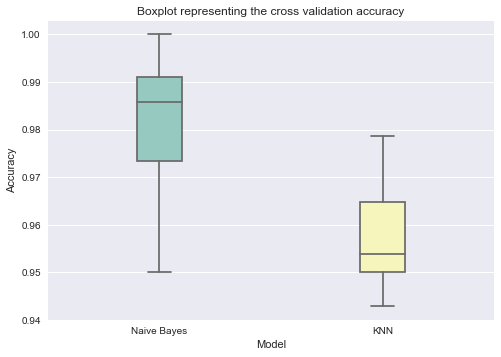

In [37]:
data = [accuracies_nb, accuracies_knn]
sns.boxplot(data=data, orient='v', width = 0.2, palette="Set3")
label = ["Naive Bayes", "KNN"]
index = np.arange(len(label))
plt.xticks(index, label)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Boxplot representing the cross validation accuracy")
plt.show()

The above boxplot illustrates that both the models performed really well and gave outstanding accuracies during the 10-fold cross validation. The mean accuracy for Naive Bayes is around 0.985 and for KNN is around 0.955.  Standard deviation for both the models are almost same. 

The spread of accuracy scores across each fold is better for Naive Bayes (lies between [0.95,1.0]) than KNN (lies between [0.943,0.978]). 

The overall lowest accuracy was found in KNN (0.943) whereas the highest accuracy was found in Naive Bayes (1.0). 

Similar ranges of the boxplots prove that there is no overfitting in either of the models, and cross-validation results has proven to give good results.

Overall, Naive Bayes classifier wins against K-Nearest Neigbout classifier for this dataset.


### Density plot of Cross validation accuracy of both models

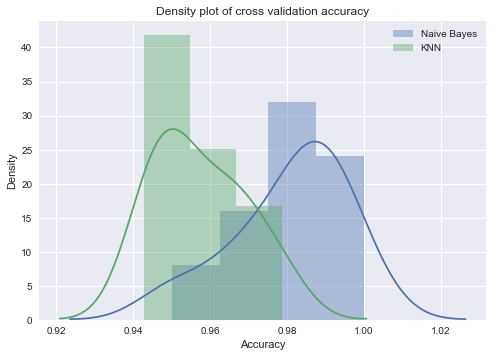

In [38]:
sns.distplot(accuracies_nb)
sns.distplot(accuracies_knn)
plt.legend(["Naive Bayes", "KNN"])
plt.xlabel("Accuracy")
plt.ylabel("Density")
plt.title("Density plot of cross validation accuracy")
plt.show()

The above density plot shows that the highest density for Naive Bayes was found near 0.985 accuracy, whereas for KNN was found near 0.95 accuracy. 

Standard deviation for both the models are almost same.

The Gaussian curve for Naive Bayes lies to the right of the KNN's curve (the mean accuracy of Naive Bayes lies to the right of mean of KNN), proving better accuracy results for Naive Bayes.

We further calculate the Cohen's Kappa coefficient - a statistic that measures *inter-annotator agreement*. It is a score that depicts the level of agreement between two annotators on a classification problem. The value lies between [-1,1].

In [39]:
print("Cohen's Kappa Score between Naive Bayes and KNN is: %.3f" % cohen_kappa_score(y_pred_knn, y_pred_nb))

Cohen's Kappa Score between Naive Bayes and KNN is: 0.952


The score is *~0.96 (which is very near to 1)* indicates high level of agreement between the two models i.e. there is less diversity between them and hence both the models will make similar kind of prediction and would give quite identical results. Hence, these using a mix of these two models won't be suitable in an ensemble, and rather they should be used independently as individual classifiers.

Here, we list down a few more comparison statistics:

| Statistic | Naive Bayes | K-Nearest Neighbour        
| :- | :-| :-
| Test set Accuracy| 97.5%  | 95.7%
| Validation set accuracy: Mean | 98% | 96%
| Validation set accuracy : Standard deviation | 0.01 | 0.01
| Average Precision | 0.98 | 0.96
| Average Recall | 0.98 | 0.96
| Average F1 Score | 0.98 | 0.96
| Count of (True Positives + True Negatives) | 275 | 270



Cross validation mean accuracy is higher for Naive Bayes (97.5%) than KNN (95.7%). Both classifiers have better mean cross validation accuracy than their test accuracy, and it illustrates that there is no overfitting in the models, and they have been tuned very well.

Average Precision for three target classes and Average Recall for three target classes is greater in case of Naive Bayes (0.98) than KNN (0.96). 

We see that both models have predicted the target labels quite well, and the predicted label counts are almost nearly equal to the actual label counts for both the models. Sum of True positive and True negative counts are higher in Naive Bayes, and hence Naive Bayes again gets an edge over KNN since the predicted labels more closely match to true labels.

On the basis of the above comparisons and visualisations, we can infer that ***Naive Bayes performs well and is a better classification model than K-Nearest neighbour for classifying news articles from the given website***.
